# Test Data Scientist
### Alan García Zermeño
8/8/2024
## The lapidarist problem

The limousine comes to a full stop. As the driver gets out to open the door you take a deep breath and get inside. Inside the meeting room you find the Prime Minister, accompanied by a fat, tall man and a short, deform one with long ears and an even longer nose.

  - **Prime Minister**: “Ah! You’re here! Great! Let me introduce my guests. This is Fidelious, Minister of Magic, and Krenk, the owner of the Gringotts Wizarding Bank.”

  - **You**: “Uhhh, ma’am, is this a joke?”

  - **Fidelious**: “Not at all, but don’t worry, don’t sweat the details, tomorrow you won’t remember anything. Security measures, you see.”

  - **Krenk**: “Let’s move things along. I don’t like to be exposed to Muggles.”

  - **You**: “What...” The Prime Minister interrupts you.

  - **Prime Minister**: “Our friends here seem to have run into a bit of an issue, see, some diamonds seem to have been stolen from the bank. Problem is, the only person... goblin, sorry, ...who saw the diamonds prior to the robbery is our distinguished guest, Krenk.”

  - **Fidelious**: “And while the Ministry completely believes Krenk as to the diamonds’ worth, we need another person to validate his claim. Safety policies, you see.”

  - **Prime Minister**: “So, since you’re the best data scientist in our country, I thought you could help. Mr. Krenk will provide you with the characteristics of the missing diamonds so you can give us an estimate of how much the stolen diamonds are worth.”

  - **You**: “But I’m not a lapidarist.”

  - **Prime Minister**: “Which is why we’re providing you with a huge dataset, containing characteristics and prices for tens of thousands of diamonds. Now, get working.“

*“Huge? Tens of thousands?“ You think. “And I thought I was the clueless one here.”*

## Exploring the database

*Ok, I am not a lapidarist but it shouldn't be so hard to understand the basics, Let's first import some of my trusted tools for work. Let's use pandas and the provided dataset I saved in my Gdrive.*

In [22]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
from tqdm.notebook import tqdm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [34]:
coor_dir = "/content/drive/MyDrive/Temporal/diamonds/coords_diamonds.csv"
data_dir = "/content/drive/MyDrive/Temporal/diamonds/diamonds.csv"
data = pd.read_csv(data_dir,index_col=0)
coor = pd.read_csv(coor_dir,index_col=0)
#data = pd.concat([data,coor],axis = 1)
data

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53925,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53926,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53927,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53928,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


*So... this is what our database looks like, almost 54k instances, it seems that we have another file with world coordinates that corresponds to each entry in this database. Let's first focus on these basic characteristics of a diamond.*
*Let's investigate what all these characteristics tell us and which ones are most important in describing a diamond.*

1. *Even I know that **carat** weight is important when valuing diamonds.A carat is a unit of measurement used in the diamond industry to specify the **weight** of a diamond. A carat equals 0.2 grams, so a 5-carat stone weighs 1 gram.*

2. **Cut** *is a categorical measure of how well the diamond is cut, it seems that the better the cut, the better it reflects light, thus the greater the brilliance.*

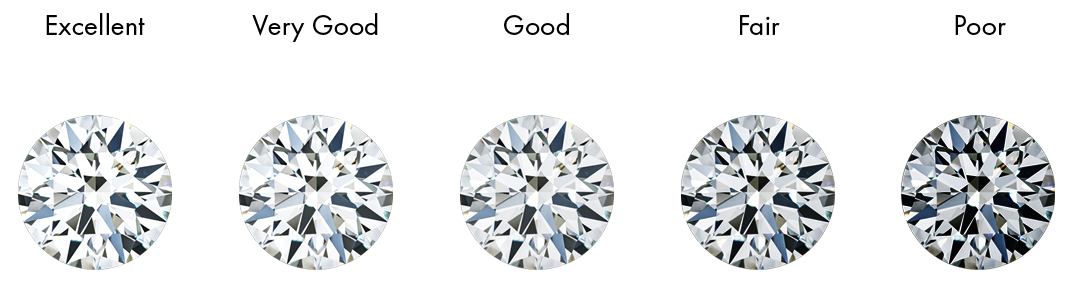

3- **Color** *is a very self-explanatory characteristic, with letters of the alphabet used to classify them. It seems that the most expensive and clearest color of all is classified as D, and the more yellowish the diamond, the higher up the alphabet you go.*

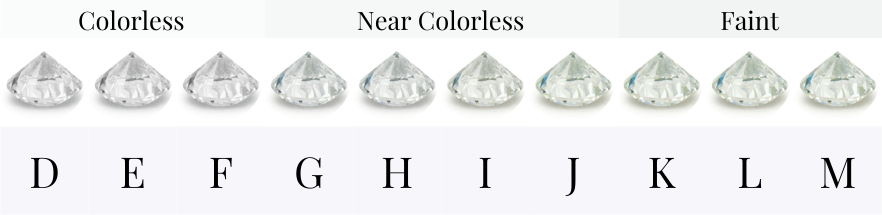

4. **Clarity** *seems to indicate the level of **impurities** a diamond contains. The following image is a good guide to understanding the scale. Obviously, the price of a diamond should be closely related to the level of impurities.*

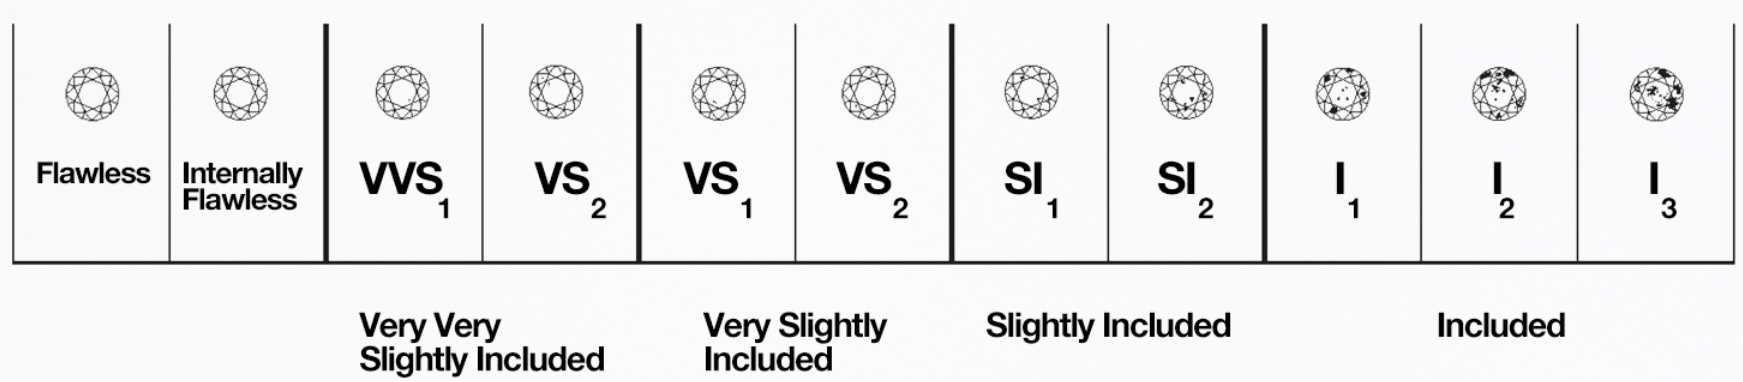

*Depth and table are proportions. It seems that a diamond must have very specific proportions to optimize its brilliance.*

5- **Depth** *is a proportion of the size relative to the height of the diamond, appears to be optimal and most expensive when it is between 59% and 62%.*

6- **Table** *is a relative proportion of the top of a diamond to its width, its ideal proportion should be between 55% and 60%.*

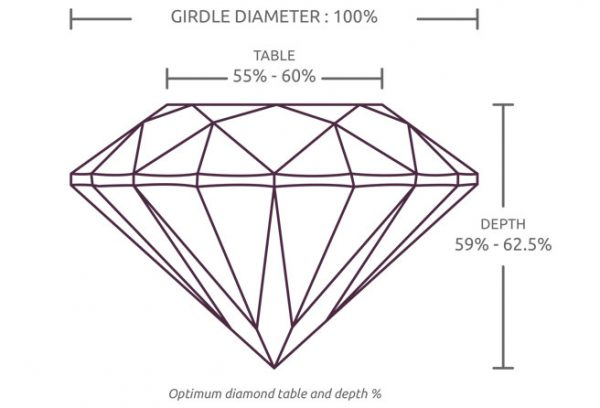

*Finally, we have x, y, and z. These simply give us the 3-dimensional measurements of our diamond. With these three measurements, its depth, and its table, we could reconstruct a 3D figure.
We also have coordinates, which seem to tell us where our diamond was found or made. **We won't be using these features for now**.*

*Let's take a look at our set of categorical variables.*

In [ ]:
data.cut.unique(), data.color.unique(), data.clarity.unique()

(array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair', 'Very Goo!d',
        "P*'remium", 'I#deal', '#Very Good', 'P?remium', "*'Ideal",
        '!Good', 'Pre!mium', 'Pr?emium', 'Very Go#od', 'Ide&al', 'Ide!al',
        'Id!eal', '&Premium', 'Go?od', 'G#ood', "Very *'Good", "Ide*'al",
        'V&ery Good', '&Ideal', 'Very G#ood'], dtype=object),
 array(['E', 'I', 'J', 'H', 'F', 'G', 'D', "*'E", '#F', '&G', '!H', '?J',
        '#D', '&I', '!I', '?G', '#H', '?H', '?E', "*'F", '!E', '&F', '#G',
        "*'I", '!F', '&E'], dtype=object),
 array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF', 'S?I1',
        'SI!1', '&VS2', '&SI2', "S*'I1", 'VS?1', "S*'I2", '#VS1', 'V&S2',
        'V!S2', '!VS2', 'VS#2', "VVS*'2", "*'SI2", 'VV?S1', 'S&I1',
        "*'SI1", 'SI?1', 'VV#S1', 'V#S2', '#SI!1', 'S!I2'], dtype=object))

*Ok, it seems that Krenk either didn't clean the dataset or he's playing a trick on me. There are random characters placed over all of these categories. With a simple regular expression we can clean them up to just letters and numbers (which is what we're looking for).*

In [35]:
def cleanDiamond(tipo):
    tipoc = re.sub(r'[^a-zA-Z1-9\s]', '', tipo)
    return tipoc

data.cut = data.cut.apply(cleanDiamond)
data.color = data.color.apply(cleanDiamond)
data.clarity = data.clarity.apply(cleanDiamond)

data.cut.unique(), data.color.unique(), data.clarity.unique()

(array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object),
 array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object),
 array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
       dtype=object))

*Much better!*

*Now, with a quick look we can see that we have some NAN values ​​in depth, x and y. We want to use the entire database, so we will fill these empty spaces with the median value of each of these characteristics, this way we will have very little effect on our estimates.*

In [ ]:
data[data.depth.isnull()].index

Index([   19,    73,   104,   110,   116,   120,   126,   131,   149,   160,
       ...
       53718, 53719, 53732, 53734, 53760, 53877, 53895, 53904, 53908, 53929],
      dtype='int64', length=2962)

In [36]:
data['x'] = data['x'].fillna(data['x'].median())
data['y'] = data['y'].fillna(data['y'].median())
data['depth'] = data['depth'].fillna(data['depth'].median())

In [ ]:
data.describe()

,carat,depth,table,price,x,y,z
count,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000,53930.000000
mean,0.797976,61.752203,57.457328,3933.054942,5.729998,5.732862,3.538141
std,0.474035,1.393089,2.234578,3989.628569,1.116127,1.135658,0.708909
min,0.200000,43.000000,43.000000,326.000000,-6.370000,-6.610000,-4.060000
25%,0.400000,61.100000,56.000000,950.000000,4.730000,4.730000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5325.000000,6.530000,6.530000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## General Stats
*Now that our database is clean, we can do some statistics to try to understand some important details of our database. Clearly our most important feature is price, let's look at its distribution.*

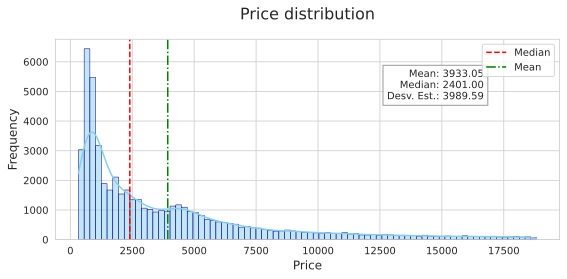

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.figure(figsize=(8, 4))
ax = sns.histplot(data.price, kde=True, color="skyblue", edgecolor="darkblue")
median = np.median(data.price)
mean = np.mean(data.price)
plt.axvline(median, color='red', linestyle='--', label='Median')
plt.axvline(mean, color='green', linestyle='-.', label='Mean')
plt.title('Price distribution', fontsize=16, pad=20)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

stats_text = f'Mean: {mean:.2f}\nMedian: {median:.2f}\nDesv. Est.: {np.std(data.price):.2f}'
plt.text(0.85, 0.85, stats_text, transform=plt.gca().transAxes,
         ha='right', va='top', bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8),
         fontsize=10)

plt.tight_layout()
plt.show()

*The vast majority of diamonds are found in the \$300 to \$5,000 range. Although we can find a few that reach up to \$18,000. It will be important to understand the relationships of all the variables with the price, there seems to be many things to consider when valuing a diamond. Perhaps, we can use a correlation chart to analyze the numerical variables.*

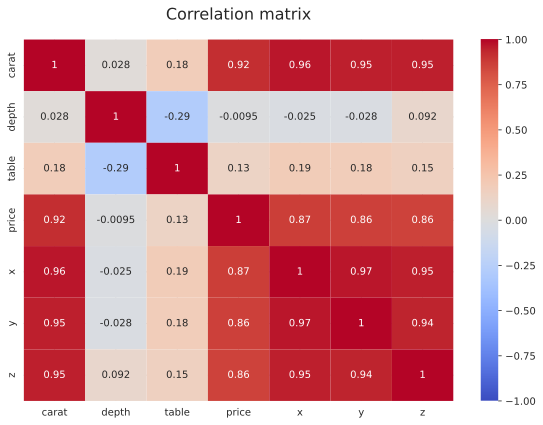

In [ ]:
df_numeric = data.select_dtypes(include=['float64', 'int64'])
corr_matrix = df_numeric.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

*Now that we understand the meaning of all the variables, it is not surprising that there is a high correlation between price and variables x,y,z and carat. What is a bit strange are the depth and table variables, it seems that the scale they use could be affecting the correlation with price.*

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.figure(figsize=(12, 6))

def boxpl_price(variable):
  if variable == 'clarity':
    order = ['IF','VVS1','VVS2','VS1','VS2','SI1','SI2','I1']
  elif variable == 'color':
    order = ['J','I','H','G','F','E','D']
  elif variable == 'cut':
    order = ['Fair','Good','Very Good','Ideal','Premium']
  ax = sns.boxplot(x=variable, y='price', data=data, width=0.6, order = order)
  plt.title('Price by '+variable, fontsize=16, pad=20)
  plt.xlabel(variable, fontsize=12)
  plt.ylabel('Price', fontsize=12)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.xticks(rotation=45, ha='right')
  plt.axhline(y=median, color='r', linestyle='--', alpha=0.5, label='Global median')
  plt.ylim(0, data.price.quantile(0.99))
  plt.legend()
  plt.tight_layout()
  plt.show()

<Figure size 1200x600 with 0 Axes>

*Categorical variables are a bit more complicated to relate to price, however, we can separate diamonds into groups and analyze their price distribution to try to decipher patterns.*

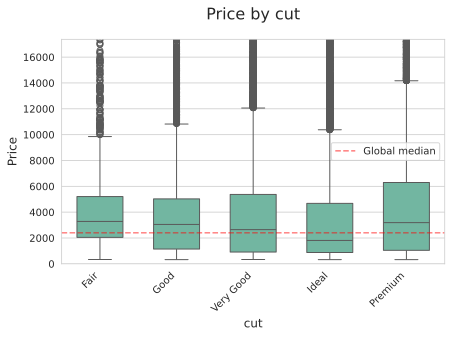

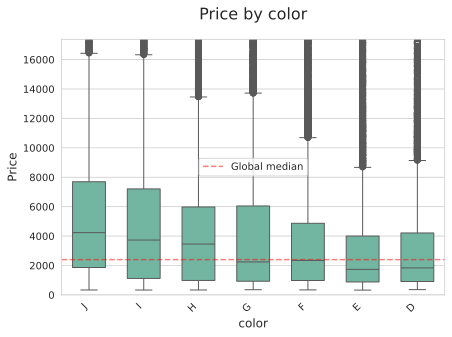

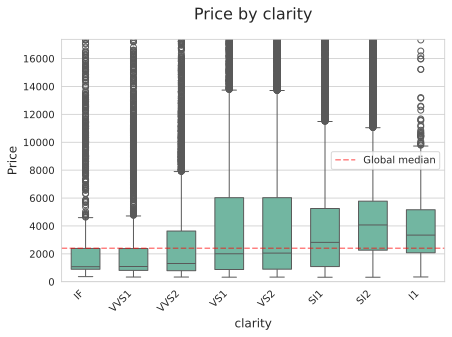

In [ ]:
boxpl_price('cut')
boxpl_price('color')
boxpl_price('clarity')

1. *In the cut boxplot, we clearly see that the price distribution for the premium cut is considerably higher, while the rest of the cuts seem similar.*
2. *The color of the diamond seems to have a lot to do with price, however, it seems clear that the more yellowish the diamond is, the more expensive it can be at Gringotts, contrary to what I thought.*
3. *Finally, clarity also seems important. The distributions of the intermediate impurity scales are clearly the most varied. However, the ones that we thought could be more expensive turn out to have a lower price distribution. This surely has to do with the size of the diamonds and we need to analyze the connections between variables more deeply.*

In [ ]:
model = ols('price ~ C(cut)', data=data).fit()
anova_results = anova_lm(model)
print(anova_results)

               df        sum_sq       mean_sq           F         PR(>F)
C(cut)        4.0  1.105546e+10  2.763864e+09  175.893275  5.636751e-150
Residual  53925.0  8.473398e+11  1.571330e+07         NaN            NaN


In [ ]:
model = ols('price ~ C(color)', data=data).fit()
anova_results = anova_lm(model)
print(anova_results)

               df        sum_sq       mean_sq           F  PR(>F)
C(color)      6.0  2.686822e+10  4.478036e+09  290.392431     0.0
Residual  53923.0  8.315270e+11  1.542064e+07         NaN     NaN


In [ ]:
model = ols('price ~ C(clarity)', data=data).fit()
anova_results = anova_lm(model)
print(anova_results)

                 df        sum_sq       mean_sq           F         PR(>F)
C(clarity)      7.0  2.331116e+10  3.330165e+09  215.031239  1.846078e-316
Residual    53922.0  8.350841e+11  1.548689e+07         NaN            NaN


*We also performed an ANOVA analysis for these 3 variables in relation to price to ensure that they are significant. In all 3 cases we obtain a p-value very close to 0, so it seems clear that they are very important in explaining the variability of diamond prices.*

## Training a model
*With this information, we are now more or less clear that all (depth and table not so much) the variables are important to calculate the price. It is time to try to create a model that explains the price variation using all the variables except the geological coordinates, with slight modifications.*

In [37]:
def trans_geo(var):
  tipoc = re.sub(r'[^-.?0-9\s]', '', var)
  return float(tipoc)

def trans_clar(var):
  clari = {'IF':1.0,'VVS1':0.92,'VVS2':0.8,'VS1':0.64,'VS2':0.48,'SI1':0.32,'SI2':0.16,'I1':0.0}
  return clari[var]

def trans_col(var):
  col = {'J':0.0,'I':0.16,'H':0.32,'G':0.48,'F':0.65,'E':0.82,'D':1.0}
  return col[var]

def trans_cut(var):
  cutv = {'Fair':0.2,'Good':0.4,'Very Good':0.6,'Ideal':0.8,'Premium':1.0}
  return cutv[var]

def transform_to_optimal_scale(values, optimal_value, decay_rate=0.2):
    distances = np.abs(values - optimal_value)
    scaled_values = np.exp(-decay_rate * distances)
    return scaled_values

def transform_data(df):
  df.cut = df.cut.apply(trans_cut)
  df.color = df.color.apply(trans_col)
  df.clarity = df.clarity.apply(trans_clar)
  df.depth = transform_to_optimal_scale(df.depth, optimal_value=60.75)
  df.table = transform_to_optimal_scale(df.table, optimal_value=57.5)
  #df.latitude = df.latitude.apply(trans_geo)
  #df['longitude '] = df['longitude '].apply(trans_geo)
  return df

df = transform_data(data)

*We will use our categorical variables in the form of a scale from 0 to 1. So we make a very basic transformation where the worst cut will have a value close to 0 and the best, close to 1. The same applies to the clarity and color variables.*

*We will also normalize the depth and table scales. To do this we will define their respective optimal value as 1, and using a decay factor we will make it closer to 0 the further their percentages are from their optimal value.*

*Now that our data is cleaned and transformed to a convenient scale, we can try to create statistical models.*

### Simple linear Regression

*The most responsible thing to do would be to start with something simple. A linear regression can give us a good first approximation. To train a model of this nature, we will randomly split our database into an evaluation set (20%) and a training set (80%). As an extra, we will scale our set of prices using the logarithm operation, this will allow us to work with more appropriate scales for the proper functioning of the model.*

In [ ]:
df = data
X = df#[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
y_train_log = np.log1p(y_train)

model = LinearRegression()
model.fit(X_train, y_train_log)

LinearRegression()

*To measure the effectiveness of the model we will use the root mean square error (RMSE) comparing the predictions of our model on the test set with respect to the real prices. This will tell us how much of a price difference we are wrong on average across the entire test set. In this test we get an RMSE of 1827.21, it might not be a bad first approximation, but we need to keep testing.*

In [ ]:
y_pred = np.exp(model.predict(X_test))
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.2f}')

RMSE: 1827.21


*Here are some examples of price predictions on the test set compared to their actual price. I think they are generally reasonable approximations.*

In [ ]:
for i in range(12):
  print(f"Real price: {y_test.iloc[i]} ------> Our linear prediction: {round(y_pred[i],2)}")

Real price: 909 ------> Our linear prediction: 943.0
Real price: 2495 ------> Our linear prediction: 2382.37
Real price: 871 ------> Our linear prediction: 1143.97
Real price: 2141 ------> Our linear prediction: 2031.42
Real price: 1013 ------> Our linear prediction: 824.82
Real price: 8246 ------> Our linear prediction: 6242.59
Real price: 2396 ------> Our linear prediction: 2115.28
Real price: 3981 ------> Our linear prediction: 3447.7
Real price: 695 ------> Our linear prediction: 761.33
Real price: 5982 ------> Our linear prediction: 4799.38
Real price: 625 ------> Our linear prediction: 686.24
Real price: 2278 ------> Our linear prediction: 2128.4


*We also tested using the geological coordinates of the diamonds, the resulting RMSE (2230.71) was worse than that obtained without taking into account coordinates.*

In [ ]:
y_pred = np.exp(model.predict(X_test))
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.2f}')

MSE: 2230.71


### Epsilon-Support Vector Regression (SVR)

*Could we get better results by using a more complex model?
We will now try an Epsilon-Support Vector Regression (SVR). The complexity is much higher than the linear model, but we want to explore how much the predictions improve when we scale the complexity.*

In [38]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

*Here we will use the same procedure, dividing the database into a test set and an evaluation set, then we will scale the data and do different tests with different parameters (C and epsilon).*

In [39]:
svr = SVR(kernel='rbf', C=3000, epsilon=0.01)
svr.fit(X_train_scaled, y_train)

SVR(C=3000, epsilon=0.01)

In [ ]:
y_pred = svr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE, C=1000, epsilon = 0.1: {np.sqrt(mse):.2f}')

RMSE, C=1000, epsilon = 0.1: 620.22


In [ ]:
y_pred = svr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE, C=500, epsilon = 0.2: {np.sqrt(mse):.2f}')

RMSE, C=500, epsilon = 0.2: 638.51


In [40]:
y_pred = svr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE, C=3000, epsilon = 0.01: {np.sqrt(mse):.2f}')

RMSE, C=3000, epsilon = 0.01: 594.79


*The RMSE error obtained using C = 1000 and epsilon = 0.1 was 620.22, significantly improving the results of the linear model. On the other hand, using C = 500 and epsilon = 0.2, gives an error of RMSE = 638.95.*

*But the best results were obtained with C = 3000 and epsilon = 0.01. Obtaining an RMSE = 594.79*

*Here are some examples of price predictions on the test set compared to their actual price.*

In [41]:
for i in range(12):
  print(f"Real price: {y_test.iloc[i]} ------> Our SVR prediction: {round(y_pred[i],2)}")

Real price: 855 ------> Our SVR prediction: 797.28
Real price: 736 ------> Our SVR prediction: 796.05
Real price: 2040 ------> Our SVR prediction: 2268.95
Real price: 1369 ------> Our SVR prediction: 1509.39
Real price: 716 ------> Our SVR prediction: 764.86
Real price: 1169 ------> Our SVR prediction: 1224.69
Real price: 10114 ------> Our SVR prediction: 10249.79
Real price: 5710 ------> Our SVR prediction: 5451.48
Real price: 1060 ------> Our SVR prediction: 1021.71
Real price: 8030 ------> Our SVR prediction: 7012.39
Real price: 15460 ------> Our SVR prediction: 15729.4
Real price: 4629 ------> Our SVR prediction: 4359.25


*This model appears to be powerful enough to make a consistent estimate of stolen diamonds.*

## Geography

*Finally, we will use the geological coordinates of the test prices that our model fails to predict the most. Maybe we can find some representative pattern that tells us something we have not considered. To do this, we will use the reverse_geocoder library to extract the country of origin of the diamond according to its coordinates.*

In [26]:
!pip install reverse_geocoder

In [ ]:
index_test = y_test.index
index_rares = []
for i in range(len(y_pred)):
  if abs(y_pred[i]-y_test.iloc[i]) > 600:
    index_rares.append(index_test[i])

In [27]:
import reverse_geocoder as rg
def obtener_pais(latitud, longitud):
    result = rg.search((latitud, longitud))
    if result:
        return result[0]['cc']
    return "Desconocido"

country = []
c_lat = coor.latitude.to_numpy()
c_long = coor['longitude '].to_numpy()
for ind in tqdm(index_rares):
  pais = obtener_pais(float(c_lat[ind]), float(c_long[ind]))
  country.append(pais)

In [ ]:
def contar_frecuencias(paises):
    frecuencias = {}
    for pais in paises:
        if pais in frecuencias:
            frecuencias[pais] += 1
        else:
            frecuencias[pais] = 1
    return frecuencias

In [ ]:
print(contar_frecuencias(country))

{'US': 1278, 'GB': 51, 'CA': 67, 'IR': 1, 'RO': 1, 'FR': 2, 'HU': 1, 'LK': 1, 'MX': 5, 'MY': 1, 'JO': 1, 'BR': 2, 'NZ': 4, 'NL': 5, 'PH': 2, 'JP': 1, 'EC': 1, 'BE': 2, 'TR': 1, 'AU': 9, 'AE': 3, 'CL': 1, 'ZA': 1, 'IN': 2, 'DK': 1, 'CY': 1, 'NO': 2, 'LT': 1, 'SG': 1, 'ES': 1, 'DZ': 1, 'PL': 1, 'SI': 1}


*The vast majority of diamonds with the worst prediction come from the USA, Great Britain and Canada. A similar distribution to that obtained from the global database. Therefore, there does not seem to be a clear relationship between the geolocation of diamonds and their price.*

## Veredict
*We will now use our best model (SVR: C=3000, epsilon=0.0.1) to estimate the price of the stolen diamonds.*

In [24]:
lost_diam = np.array([[0.71,'Good','I','VVS2',63.1,58,5.64,5.71,3.58,35.02636,-114.38351],
                      [0.83,'Ideal','G','VS1',62.1,55,6.02,6.05,3.75,35.00350,-109.78961],
                      [0.5,'Ideal','E','VS2',61.5,55,5.11,5.16,3.16,35.10544,-106.669673],
                      [0.39,'Premium','J','VS1',61.6,59,4.67,4.71,2.89,34.94666,-104.64730],
                      [0.32,'Premium','G','VS1',62.1,56,4.43,4.4,2.74,35.18864,-101.98602],
                      [0.9,'Good','F','SI2',63.3,57,6.08,6.14,3.87,35.26611,-99.63874],
                      [0.51,'Ideal','D','VS1',60.9,57,5.2,5.17,3.16,35.51572,-97.67080],
                      [1.12,'Ideal','G','VVS2',62.1,54.8,6.64,6.66,4.13,36.163605, -95.75950],
                      [0.4,'Ideal','G','VVS2',62.4,56,4.72,4.74,2.95,37.689186, -92.6473],
                      [0.36,'Premium','I','VS2',62.7,59,4.54,4.58,2.86,38.66303, -90.21808]])

lost_df = pd.DataFrame(lost_diam,columns=['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z','latitude','longitude '])
lost_df.depth = lost_df.depth.astype(float)
lost_df.table = lost_df.table.astype(float)
lost_df_ori = lost_df.copy()

In [25]:
lost_df

,carat,cut,color,clarity,depth,table,x,y,z,latitude,longitude
0,0.71,Good,I,VVS2,63.1,58.0,5.64,5.71,3.58,35.02636,-114.38351
1,0.83,Ideal,G,VS1,62.1,55.0,6.02,6.05,3.75,35.0035,-109.78961
2,0.5,Ideal,E,VS2,61.5,55.0,5.11,5.16,3.16,35.10544,-106.669673
3,0.39,Premium,J,VS1,61.6,59.0,4.67,4.71,2.89,34.94666,-104.6473
4,0.32,Premium,G,VS1,62.1,56.0,4.43,4.4,2.74,35.18864,-101.98602
5,0.9,Good,F,SI2,63.3,57.0,6.08,6.14,3.87,35.26611,-99.63874
6,0.51,Ideal,D,VS1,60.9,57.0,5.2,5.17,3.16,35.51572,-97.6708
7,1.12,Ideal,G,VVS2,62.1,54.8,6.64,6.66,4.13,36.163605,-95.7595
8,0.4,Ideal,G,VVS2,62.4,56.0,4.72,4.74,2.95,37.689186,-92.6473
9,0.36,Premium,I,VS2,62.7,59.0,4.54,4.58,2.86,38.66303,-90.21808


In [ ]:
transform_data(lost_df)
lost = lost_df.drop(['latitude','longitude '], axis=1)

In [ ]:
lost_transf = scaler.fit_transform(lost)
price = svr.predict(lost_transf)

In [28]:
country = []
c_lat = lost_df.latitude.to_numpy()
c_long = lost_df['longitude '].to_numpy()
for la,lo in tqdm(zip(c_lat,c_long)):
  pais = obtener_pais(float(la), float(lo))
  country.append(pais)

0it [00:00, ?it/s]

*To do this, we transformed the data as we did before and used geolocations to find out that all the stolen diamonds originated in the USA.*

In [ ]:
country

['US', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'US']

In [ ]:
pd.concat([lost_df_ori,pd.DataFrame(np.round(price,2),columns=['price'])],axis = 1)

,carat,cut,color,clarity,depth,table,x,y,z,latitude,longitude,price
0,0.71,Good,I,VVS2,63.1,58.0,5.64,5.71,3.58,35.02636,-114.38351,4879.61
1,0.83,Ideal,G,VS1,62.1,55.0,6.02,6.05,3.75,35.0035,-109.78961,8929.52
2,0.5,Ideal,E,VS2,61.5,55.0,5.11,5.16,3.16,35.10544,-106.669673,1943.69
3,0.39,Premium,J,VS1,61.6,59.0,4.67,4.71,2.89,34.94666,-104.6473,701.83
4,0.32,Premium,G,VS1,62.1,56.0,4.43,4.4,2.74,35.18864,-101.98602,771.18
5,0.9,Good,F,SI2,63.3,57.0,6.08,6.14,3.87,35.26611,-99.63874,2604.69
6,0.51,Ideal,D,VS1,60.9,57.0,5.2,5.17,3.16,35.51572,-97.6708,2676.45
7,1.12,Ideal,G,VVS2,62.1,54.8,6.64,6.66,4.13,36.163605,-95.7595,19313.03
8,0.4,Ideal,G,VVS2,62.4,56.0,4.72,4.74,2.95,37.689186,-92.6473,1227.56
9,0.36,Premium,I,VS2,62.7,59.0,4.54,4.58,2.86,38.66303,-90.21808,582.82


In [ ]:
error = np.sqrt(len(price)*mse)
print(f"Total estimated lost = ${round(np.sum(price),2)} ± ${round(error,2)}")

Total estimated lost = $43630.37 ± $1880.88


*Since we have our predictions, we can conclude, Mr. Prime Minister, that the stolen diamonds amount to an approximate economic loss of \$43,630.37 ± \$1,880.88.
Taking into account that on average one of your random diamonds costs $2,401 and therefore 10 random diamonds cost approximately \$24,010. I dare say that the thieves knew about diamonds, because they managed to take 10 diamonds that together, practically double the average cost.*